# Solutions of exercises for Chapter 4

In [126]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf


In [3]:
pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")
register_matplotlib_converters()
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

The data set in file csco_levelIII_data.csv on the entire trading session, including early and late hours from 6:00 a.m. to 8:00 p.m. EST, contains intraday activity for up to 5 major national exchanges: Nasdaq, Direct Edge, NYSE, ARCA, and BATS (exact number of exchanges depends on the historical period). All messages are consolidated into one file ordered by timestamp. This data set allows to build a full national depth book (super book) at any moment intraday. The details of Level III data are given in Table 1.10.


### Exercise 1

You need to aggregate the data into 5-min intervals before answering the following.
1. Let $x_t$ denote the number of trades in the $t$th 5-minute interval. Ignore the time gaps between trading days. Plot the time series and its ACF. Determine if there are intraday period patterns in the series.
1.  Using the last transaction in the $t$th 5-minute interval as the stock price in that interval, plot the time series $y_t$ of 5-minute returns during the period and the corresponding ACF.
1. Consider the bivariate time series ($x_t$, $y_t$). How does $y_t$ vary with $x_t$? Are there any intraday periodic patterns in ($x_t$, $y_t$)?
1.  Plot the durations of the transaction times for Mondays and Fridays. Is there any difference in the patterns?
1. Fit GARCH models for the durations and interpret the coefficients.
1. Is there any particular exchange that offers better price?

#### Part 1

Let's load the data and process it with the same book parser we created for Chapter 2 Exercise 8. In this case we let it completely parse for the whole day.

In [76]:
csco_data = pd.read_csv('../datasets/csco_levelIII_data.csv')
dt = datetime.date(2020,8,1) #Random Date
csco_data.Timestamp = pd.to_datetime(csco_data.Timestamp,unit='ms',origin=dt)
csco_data = csco_data.drop(columns=['Ticker','MPID'])
csco_data.head()

,Timestamp,OrderNumber,Event,Quantity,Price,Exchange
0,2020-08-01 04:00:00.059,281487861612558,B,950,187000,P
1,2020-08-01 04:00:00.059,281487861613765,B,54,185300,P
2,2020-08-01 04:00:00.059,281487861612817,B,25,180000,P
3,2020-08-01 04:00:00.059,281487861612863,B,10,177000,P
4,2020-08-01 04:00:00.059,281487861612816,B,25,175000,P


In [74]:
class objdict(dict):
      
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)

def process_book_data(data,end_time=None):
    
    order_book = objdict()
    order_book.Buy = objdict()
    order_book.Sell = objdict()
    order_book.Orders = objdict()
    trades = []
    columns = data.columns
    if end_time:
        book_data = data.loc[data.Timestamp < end_time,:]
    else:
        book_data = data
        
    book_data = book_data.to_dict(orient='record')
    
    for event in book_data:
    
        event = objdict(event)
        
        o_num_unique = f'{event.OrderNumber}_{event.Exchange}' # OrderNumber only unique on a specific exchange
            
        if event.Event == 'B': # Buy Order
            order_book.Orders[o_num_unique] = 'Buy'
            order_book.Buy[o_num_unique] = event
            
        elif event.Event == 'S': #Sell Order
            order_book.Orders[o_num_unique] = 'Sell'
            order_book.Sell[o_num_unique] = event
            
        elif event.Event == 'D': # Delete 
            side = order_book.Orders[o_num_unique]
            del order_book.Orders[o_num_unique]
            del order_book[side][o_num_unique]
            
        elif event.Event == 'C': # Partial Cancellation
            side = order_book.Orders[o_num_unique]
            order = order_book[side][o_num_unique]
            qty = int(event.Quantity)
            
            order.Quantity -=qty
            if order.Quantity <= 0:
                del order_book.Orders[o_num_unique]
                del order_book[side][o_num_unique]
            else:
                order_book[side][o_num_unique] = order
            
        elif event.Event == 'T': #Dark Execution
            qty = int(event.Quantity)
            price = float(event.Price)/10000.0
            trade = objdict({
                'Timestamp': event.Timestamp,
                'Price': price,
                'Quantity': qty,
                'Type': 'Dark'
            })

            trades.append(trade)

        elif event.Event == 'F': #Lit Full Execution
            side = order_book.Orders[o_num_unique]
            order = order_book[side][o_num_unique]
            qty = int(order.Quantity)
            price = float(order.Price)/10000.0

            trade = objdict({
                'Timestamp': event.Timestamp,
                'Price': price,
                'Quantity': qty,
                'Type': 'Lit'
            })

            trades.append(trade)

            del order_book.Orders[o_num_unique]
            del order_book[side][o_num_unique]
            
        elif event.Event == 'E': #Lit Partial Execution
            side = order_book.Orders[o_num_unique]
            order = order_book[side][o_num_unique]
            qty = int(event.Quantity)
            price = float(order.Price)/10000.0

            trade = objdict({
                'Timestamp': event.Timestamp,
                'Price': price,
                'Quantity': qty,
                'Type': 'Lit'
            })

            trades.append(trade)

            order.Quantity -=qty
            if order.Quantity <= 0:
                del order_book.Orders[o_num_unique]
                del order_book[side][o_num_unique]
            else:
                order_book[side][o_num_unique] = order
        elif event.Event == 'X': #Auction Cross
            qty = int(event.Quantity)
            price = float(event.Price)/10000.0
            trade = objdict({
                'Timestamp': event.Timestamp,
                'Price': price,
                'Quantity': qty,
                'Type': 'Cross'
            })

            trades.append(trade)
        else:
            print(event)
            
    trades  = pd.DataFrame(trades)
    return (order_book,trades)

In [77]:
order_book,trades = process_book_data(csco_data)
order_book

{'Buy': {}, 'Sell': {}, 'Orders': {}}

The order book at the end of the day is empty confirming that all event have been processed correctly

In [122]:
def process_trades(df):
    num_trades = df.shape[0]
    if num_trades >0:
        last_price = df.Price.values[-1]
    else:
        last_price = 0.0
    return pd.Series({'NumTrades':num_trades,'LastPrice':last_price})

five_min_agg = trades.groupby(pd.Grouper(key='Timestamp',freq='5MIN')).apply(process_trades)
five_min_agg = five_min_agg.loc[datetime.datetime.combine(dt,datetime.time(9,30,0)):datetime.datetime.combine(dt,datetime.time(15,59,59))]

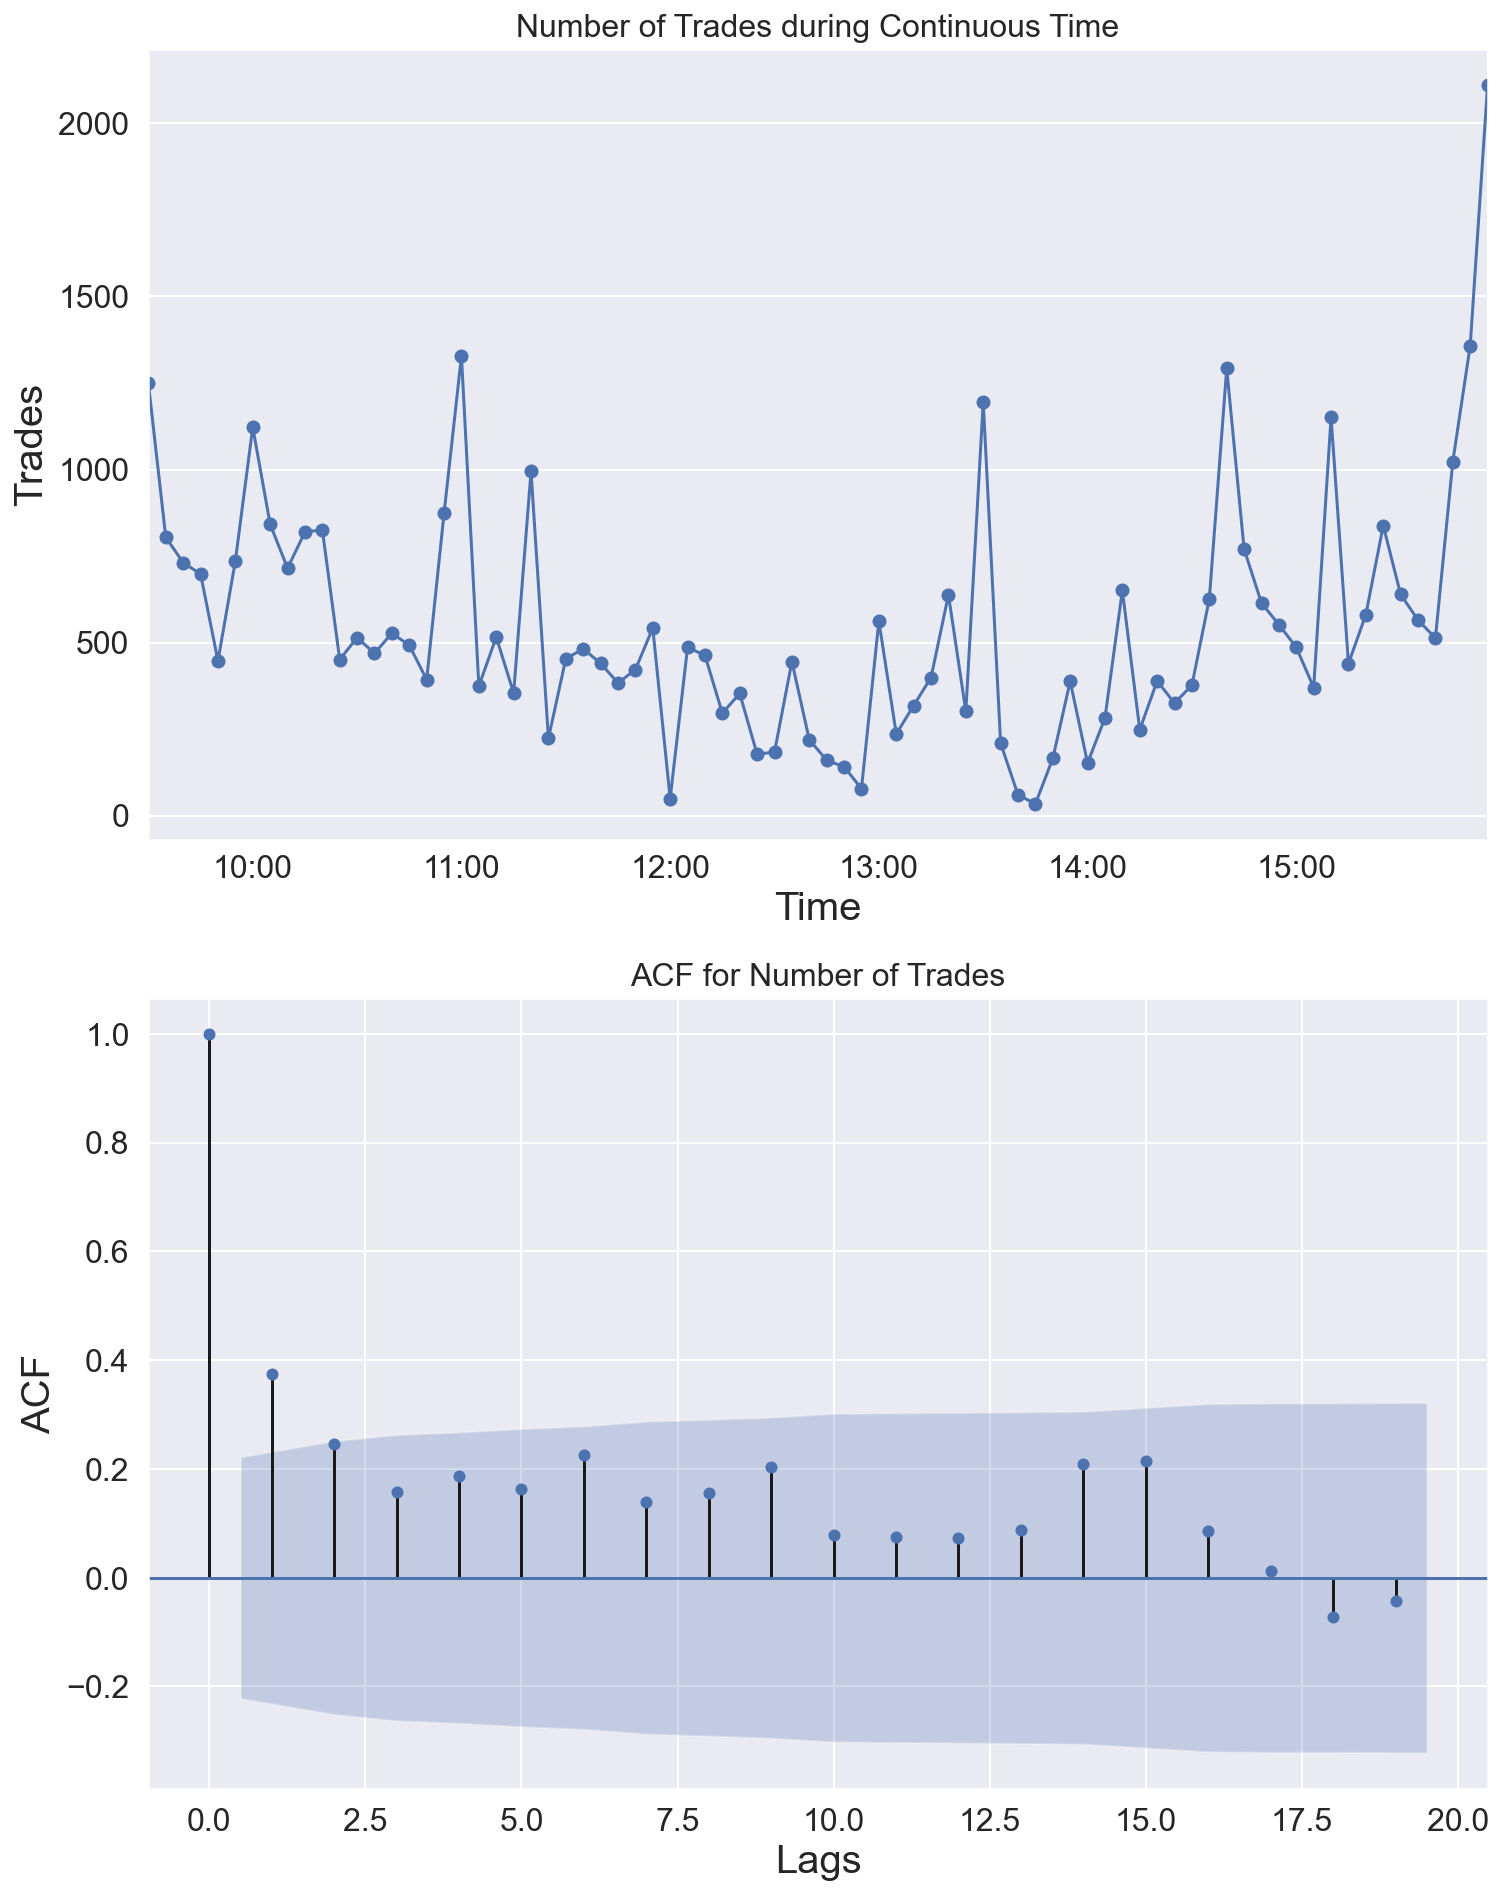

In [137]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,16))
_ = five_min_agg.NumTrades.plot(ax=ax1, marker='o')
_ = ax1.set_title('Number of Trades during Continuous Time',fontsize=16)
_ = ax1.set_xlabel('Time')
_ = ax1.set_ylabel('Trades')
_ = plot_acf(five_min_agg.NumTrades,ax=ax2)

_ = ax2.set_title('ACF for Number of Trades',fontsize=16)
_ = ax2.set_xlabel('Lags')
_ = ax2.set_ylabel('ACF')
plt.show()

In [115]:
trades.loc['09:30:00']

KeyError: '09:30:00'

,NumTrades,LastPrice
Timestamp,,
2020-08-01 09:30:00,1249.0,18.780
2020-08-01 09:35:00,804.0,18.785
2020-08-01 09:40:00,731.0,18.770
2020-08-01 09:45:00,698.0,18.735
2020-08-01 09:50:00,447.0,18.750
...,...,...
2020-08-01 15:40:00,513.0,18.765
2020-08-01 15:45:00,1023.0,18.750
2020-08-01 15:50:00,1358.0,18.740
